In [1]:
import os, h5py
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

os.makedirs("Influence/", exist_ok=True)

/home/ggj/anaconda3/envs/sc/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
dataset_fname = "../../../0_Dataset/Dataset.Smed_train_test.h5"
anno_fname = "../../../0_Annotation_Cellcluster/Smed_GSE111764.cellatlas.annotation.20201215.txt"

In [3]:
# unpack datasets
h5file = h5py.File(dataset_fname, 'r')
cell_id = h5file["celltype"][:]
h5file.close()

anno = pd.read_csv(anno_fname, sep='\t', index_col=0, header=0).loc[cell_id]
# anno['Celltype'] = anno['Celltype'].apply(lambda x: x.split('_')[-1])

sel = (anno.Cellcluster != "Other") & (anno.Cellcluster != "RP_high") & (anno.Cellcluster != "Yolk")
anno = anno[sel]

anno["Celltype"] = anno.Celltype.apply(lambda x: '_'.join(x.split('_')[1:]) + '_' + x.split('_')[0])
anno.head()

,Species,Celltype,Cellcluster
Cell,,,
Cells_Head_AAAAACTTATAA,Planarian,Cathepsin+_cells_C10,Cathepsin
Cells_Head_AAAACATAGCCC,Planarian,Cathepsin+_cells_C10,Cathepsin
Cells_Head_AAAACATTGGAT,Planarian,Cathepsin+_cells_C10,Cathepsin
Cells_Head_AAAATAGTAATA,Planarian,Cathepsin+_cells_C10,Cathepsin
Cells_Head_AAAATCTCACGG,Planarian,Cathepsin+_cells_C10,Cathepsin


In [4]:
def norm_scale_influe(influe, clip_value=None):
    adata = sc.AnnData(influe.copy())

    sc.pp.normalize_total(adata, target_sum=10)
    sc.pp.log1p(adata)
    sc.pp.scale(adata, max_value=np.inf)
    
    influe = adata.to_df().copy()
    if clip_value:
        influe = np.clip(influe, -clip_value, clip_value)

    return influe


def binary_influ(bin_influ_df, t=0.8):
    bin_influ_df = bin_influ_df.copy()

    t = np.quantile(bin_influ_df.values, t, axis=0)
    t[t < 0] = 0
    print(max(t), min(t))

    bin_influ_df[bin_influ_df <= t] = 0
    bin_influ_df[bin_influ_df > t] = 1
    bin_influ_df = bin_influ_df[bin_influ_df.sum(1) > 10]

    return bin_influ_df

In [5]:
def draw_influ_clustermap(bin_influ_df, anno, 
                          col_cluster=False, cmap='vlag', show_fig=True,
                          save_prefix="positive_influence", 
                          save_dendrogram=False): 
    #import seaborn as sns
    #import matplotlib.pyplot as plt
    #from matplotlib.patches import Patch
    
    # clustermap
    color = ("#E6AB02",  "#66A61E", "#D95F02", "#1B9E77", "#E7298A",  "#E31A1C", "#A6761D"  , "#B2DF8A",   "#FFFF99",   "#7570B3", "#FF7F00",  "#A65628", "#B3CDE3", "#BC80BD",     "#A6CEE3","#984EA3",   "#CCEBC5",  "#E41A1C",    "#4DAF4A","#BEBADA", "#B3DE69", "#CAB2D6","#FFFFB3",   "#33A02C","#B15928", "#6A3D9A","#FBB4AE",    "blue",          "#FB8072",      "#FFFF33","#CCEBC5",      "#A6761D",   "#2c7fb8","#fa9fb5",  "#BEBADA","#E7298A", "#E7298A" )
    regions = ("Secretory", "Muscle", "Neuron" , "Immune", "Epithelial", "Glia", "Proliferating","Other",  "Neoblast","Protonephridia","Phagocytes","Cathepsin","Rectum", "Coelomocytes","Intestine","Hepatocyte","Pharynx","Endothelial","Erythroid","Testis","Mesenchyme","Yolk", "Midgut" ,"Embryo","Hemocytes",  "Fat",  "Unknown","Gastrodermis","DigFilaments","Pigment","BasementMembrane","Endoderm","RP_high","FatBody","Male","Nephron", "Pancreatic")
    color_regions = {x:y for x,y in zip(regions, color)}

    anno["colors_lineage"] = anno[['Cellcluster']].applymap(lambda x: color_regions[x])
    anno_color = anno.loc[bin_influ_df.index]
    
    lut = {cluster:color_regions.get(cluster) for cluster in anno.Cellcluster.unique()}
    handles = [Patch(facecolor=lut[name]) for name in lut]
    # print(lut)
    
    plt.figure(figsize=(6, 10))
    g = sns.clustermap(bin_influ_df.T, col_cluster=col_cluster,
                       cbar_pos=None, xticklabels=False,
                       col_colors=anno_color[["colors_lineage"]],
                       cmap=cmap, figsize=(18, 30),
                       dendrogram_ratio=(.01, .1), colors_ratio=0.01)

    plt.legend(handles, lut, title='CellLieange',
               bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

    plt.savefig(save_prefix+".clustermap.pdf")
    if show_fig:
        plt.show()
    plt.close()
    
    if save_dendrogram and col_cluster:
        anno_color.iloc[g.dendrogram_col.reordered_ind,].to_csv(save_prefix+".cellanno.csv")
        print("saving dendrogram")

In [6]:
def melt_influ(bin_influ_df, Var="Celltype", t=None):
    bin_influ_df = bin_influ_df.copy()
    
    bin_influ_df['Var'] = bin_influ_df.index
    bin_influ_df = bin_influ_df.melt(id_vars='Var')
    bin_influ_df.columns = [Var, "Motif", "Influe"]
    
    if t:
        bin_influ_df = bin_influ_df[bin_influ_df.value > t]
        
    return bin_influ_df

In [7]:
sample_mask = anno.sample(1000).index #
anno_color = anno.loc[sample_mask]
anno_color.head()

,Species,Celltype,Cellcluster
Cell,,,
Cells_Trunk_TCGCTAGACCCT,Planarian,Neoblast_C0,Neoblast
Cells_Trunk_GCCATAGCATTC,Planarian,Parapharyngeal_C12,Pharynx
Cells_Tail_GCACCAAAATGA,Planarian,Protonephridia_C29,Protonephridia
Cells_Trunk_GACCTTGCATTA,Planarian,Intestine_C19,Intestine
Cells_Tail_ATAAGATTACAA,Planarian,Epidermal_C3,Epithelial


In [8]:
kernal_influence = 1 - pd.read_pickle("./influence_conv1.p", compression='xz').T.astype(float)[sel]
kernal_influence = kernal_influence.loc[sample_mask]

kernal_influence.columns = kernal_influence.columns.map(lambda x: 'Motif_' + str(x))
kernal_influence.iloc[:5,:4]

,Motif_0,Motif_1,Motif_2,Motif_3
Cell,,,,
Cells_Trunk_TCGCTAGACCCT,-0.004236,-0.082922,0.002394,-0.025425
Cells_Trunk_GCCATAGCATTC,-0.014082,-0.084870,0.001910,-0.013648
Cells_Tail_GCACCAAAATGA,-0.015534,-0.075561,0.001222,-0.008166
Cells_Trunk_GACCTTGCATTA,-0.006224,-0.154478,0.020285,-0.032195
Cells_Tail_ATAAGATTACAA,-0.003569,-0.124139,0.015536,-0.025656


# Positive influence

In [9]:
prefix = "./Influence/positive_influence"

In [10]:
influence_pos = kernal_influence.copy()
influence_pos[influence_pos < 0] = 0
influence_pos = influence_pos.loc[:,influence_pos.sum(0)!=0]
influence_pos = influence_pos.loc[anno.loc[influence_pos.index].sort_values(["Cellcluster", "Celltype"]).index]
influence_pos.iloc[:5,:4]

,Motif_0,Motif_2,Motif_4,Motif_6
Cell,,,,
Cells_Head_CTTCATTTGATG,0.0,0.000000,0.0,0.000735
Cells_Trunk_ACTTCCCCCGGN,0.0,0.007595,0.0,0.000000
Cells_Head_CTCTCTGTACTT,0.0,0.008597,0.0,0.000000
Cells_Head_TTGTCTAAAGGC,0.0,0.003522,0.0,0.000000
Cells_Pharynx_CCTCCCGCCGGC,0.0,0.014877,0.0,0.000000


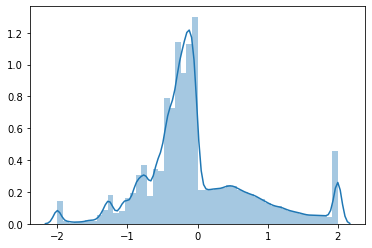

In [11]:
influence_pos = norm_scale_influe(influence_pos, clip_value=2)
sns.distplot(influence_pos.values)

In [12]:
draw_influ_clustermap(influence_pos, anno, show_fig=False,
               save_prefix=prefix, save_dendrogram=True)

<Figure size 432x720 with 0 Axes>

In [13]:
bin_influ = binary_influ(influence_pos)
bin_influ.iloc[:5,:4]

1.196873426437378 0.0


,Motif_0,Motif_2,Motif_4,Motif_6
Cell,,,,
Cells_Head_CTTCATTTGATG,0.0,0.0,0.0,1.0
Cells_Trunk_ACTTCCCCCGGN,0.0,1.0,0.0,0.0
Cells_Head_TTGTCTAAAGGC,0.0,0.0,0.0,0.0
Cells_Head_TTAGCGTACCTC,0.0,0.0,0.0,0.0
Cells_Head_AGAGAACCTACG,0.0,0.0,0.0,0.0


In [14]:
draw_influ_clustermap(bin_influ, anno, show_fig=False,
               save_prefix= prefix+"_bin", 
               col_cluster=True, cmap='Greys', 
                save_dendrogram=True)

saving dendrogram


<Figure size 432x720 with 0 Axes>

In [15]:
anno_celltype = anno_color.drop_duplicates(["Celltype", "Cellcluster"]).set_index("Celltype")
influ_celltype = influence_pos.groupby(anno_color.Celltype).mean()
influ_celltype.iloc[:5,:4]

,Motif_0,Motif_2,Motif_4,Motif_6
Celltype,,,,
Cathepsin+_cells_C10,-0.140762,0.438826,-0.165601,-0.045661
Cathepsin+_cells_C15,-0.140762,0.256865,-0.165601,-0.147944
Cathepsin+_cells_C17,-0.140762,0.606805,-0.165601,-0.147944
Cathepsin+_cells_C28,-0.140762,0.301423,-0.165601,0.281645
Cathepsin+_cells_C31,-0.140762,0.759432,-0.165601,-0.147944


In [16]:
draw_influ_clustermap(influ_celltype, anno_celltype, show_fig=False,
               save_prefix= prefix+"_celltype", 
               col_cluster=False, cmap='vlag')

<Figure size 432x720 with 0 Axes>

In [17]:
melt_influ(influ_celltype).to_csv(prefix+"_celltype.csv")

In [18]:
bin_influ_celltype = binary_influ(influ_celltype)
bin_influ_celltype.iloc[:5,:4]

1.441820621490479 0.0


,Motif_0,Motif_2,Motif_4,Motif_6
Celltype,,,,
Cathepsin+_cells_C10,0.0,0.0,0.0,0.0
Cathepsin+_cells_C15,0.0,0.0,0.0,0.0
Cathepsin+_cells_C28,0.0,0.0,0.0,1.0
Cathepsin+_cells_C39,0.0,0.0,0.0,1.0
Cathepsin+_cells_C41,0.0,1.0,0.0,0.0


In [19]:
draw_influ_clustermap(bin_influ_celltype, anno_celltype, show_fig=False,
               save_prefix= prefix+"_celltype_bin", 
               col_cluster=True, cmap='Greys', 
                save_dendrogram=True)

saving dendrogram


<Figure size 432x720 with 0 Axes>

In [20]:
anno_cluster = anno_color.drop_duplicates(["Cellcluster"])
anno_cluster.index = anno_cluster.Cellcluster

influ_cluster = influence_pos.groupby(anno_color.Cellcluster).mean()
influ_cluster.iloc[:5,:4]

,Motif_0,Motif_2,Motif_4,Motif_6
Cellcluster,,,,
Cathepsin,-0.140762,0.379913,-0.147916,-0.085230
Epithelial,-0.140762,-0.137944,-0.165601,-0.088782
Intestine,-0.140762,0.377695,-0.165601,-0.114382
Muscle,-0.140762,-0.549678,-0.165601,-0.127290
Neoblast,-0.140762,-0.183344,-0.165601,-0.004902


In [21]:
draw_influ_clustermap(influ_cluster, anno_cluster, show_fig=False,
               save_prefix= prefix+"_cluster", 
               col_cluster=True, cmap='vlag')

/home/ggj/anaconda3/envs/sc/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<Figure size 432x720 with 0 Axes>

In [22]:
melt_influ(influ_cluster, Var="Cluster").to_csv(prefix+"_cluster.csv")

In [70]:
# bin_influ_celltype_corr = bin_influ_celltype.corr()

In [19]:
# plt.figure(figsize=(1, 1))
# g = sns.clustermap(bin_influ_celltype_corr, 
#                    col_cluster=False, row_cluster=False,
#                    cbar_pos=None, xticklabels=False, yticklabels=False,
#                    col_colors=anno_celltype_color[["colors_lineage"]],
#                    row_colors=anno_celltype_color[["colors_lineage"]],
#                    cmap='vlag', figsize=(5, 5),
#                    dendrogram_ratio=(.01, .1), colors_ratio=0.01)

# handles = [Patch(facecolor=lut[name]) for name in lut]
# plt.legend(handles, lut, title='CellLieange',
#            bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

# # plt.savefig("positive.influence.clustermap.pdf")
# plt.show()
# plt.close()

# Negative influence

In [23]:
prefix = "./Influence/nagative_influence"

In [24]:
influence_neg = kernal_influence.copy()
influence_neg[influence_neg > 0] = 0
influence_neg = influence_neg.abs()
influence_neg = influence_neg.loc[:, influence_neg.sum(0) != 0]
influence_neg = influence_neg.loc[anno.loc[influence_neg.index].sort_values(["Cellcluster", "Celltype"]).index]
influence_neg.iloc[:5,:4]

,Motif_0,Motif_1,Motif_2,Motif_3
Cell,,,,
Cells_Head_CTTCATTTGATG,0.003257,0.041779,0.006262,0.018318
Cells_Trunk_ACTTCCCCCGGN,0.001572,0.104224,0.000000,0.031004
Cells_Head_CTCTCTGTACTT,0.003284,0.099307,0.000000,0.025072
Cells_Head_TTGTCTAAAGGC,0.003064,0.071938,0.000000,0.021227
Cells_Pharynx_CCTCCCGCCGGC,0.003299,0.117835,0.000000,0.026228


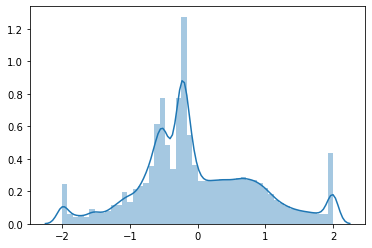

In [25]:
influence_neg = norm_scale_influe(influence_neg, clip_value=2)
sns.distplot(influence_neg.values)

In [26]:
draw_influ_clustermap(influence_neg, anno, show_fig=False,
               save_prefix=prefix, save_dendrogram=True)

<Figure size 432x720 with 0 Axes>

In [27]:
bin_influ_neg = binary_influ(influence_neg)
bin_influ_neg.iloc[:5,:4]

1.044039058685303 0.0


,Motif_0,Motif_1,Motif_2,Motif_3
Cell,,,,
Cells_Head_CTTCATTTGATG,0.0,0.0,1.0,0.0
Cells_Trunk_ACTTCCCCCGGN,0.0,0.0,0.0,1.0
Cells_Head_TTGTCTAAAGGC,0.0,0.0,0.0,1.0
Cells_Pharynx_CCTCCCGCCGGC,0.0,0.0,0.0,0.0
Cells_Head_TTAGCGTACCTC,0.0,1.0,0.0,0.0


In [28]:
draw_influ_clustermap(bin_influ_neg, anno, show_fig=False,
               save_prefix= prefix+"_bin", 
               col_cluster=True, cmap='Greys', 
                save_dendrogram=True)

saving dendrogram


<Figure size 432x720 with 0 Axes>

In [29]:
anno_celltype = anno_color.drop_duplicates(["Celltype", "Cellcluster"]).set_index("Celltype")
influence_neg_celltype = influence_neg.groupby(anno_color.Celltype).mean()
influence_neg_celltype.iloc[:5,:4]

,Motif_0,Motif_1,Motif_2,Motif_3
Celltype,,,,
Cathepsin+_cells_C10,-0.665417,0.322480,-0.073033,0.700511
Cathepsin+_cells_C15,-0.722456,0.133722,0.016380,0.973530
Cathepsin+_cells_C17,-0.580631,0.474561,-0.260389,0.525803
Cathepsin+_cells_C28,-0.734104,0.179211,0.188286,0.643710
Cathepsin+_cells_C31,-0.530957,0.517998,-0.264643,0.514624


In [30]:
draw_influ_clustermap(influence_neg_celltype, anno_celltype, show_fig=False,
               save_prefix= prefix+"_celltype", 
               col_cluster=False, cmap='vlag')

<Figure size 432x720 with 0 Axes>

In [31]:
melt_influ(influence_neg_celltype).to_csv(prefix+"_celltype.csv")

In [32]:
bin_influ_neg_celltype = binary_influ(influence_neg_celltype)
bin_influ_neg_celltype.iloc[:5,:4]

1.438775110244751 0.0


,Motif_0,Motif_1,Motif_2,Motif_3
Celltype,,,,
Cathepsin+_cells_C10,0.0,0.0,0.0,1.0
Cathepsin+_cells_C15,0.0,0.0,0.0,1.0
Cathepsin+_cells_C28,0.0,0.0,1.0,1.0
Cathepsin+_cells_C39,0.0,0.0,1.0,0.0
Cathepsin+_cells_C41,0.0,0.0,0.0,0.0


In [33]:
draw_influ_clustermap(bin_influ_neg_celltype, anno_celltype, show_fig=False,
               save_prefix= prefix+"_celltype_bin", 
               col_cluster=True, cmap='Greys', 
                save_dendrogram=True)

saving dendrogram


<Figure size 432x720 with 0 Axes>

In [34]:
anno_cluster = anno_color.drop_duplicates(["Cellcluster"])
anno_cluster.index = anno_cluster.Cellcluster

influence_neg_cluster = influence_neg.groupby(anno_color.Cellcluster).mean()
influence_neg_cluster.iloc[:5,:4]

,Motif_0,Motif_1,Motif_2,Motif_3
Cellcluster,,,,
Cathepsin,-0.524164,0.260646,-0.126058,0.518526
Epithelial,0.201600,-0.112956,-0.074173,-0.142495
Intestine,-0.330688,0.507845,-0.229258,0.266725
Muscle,0.890020,-0.598500,-0.155609,-0.805982
Neoblast,-0.125444,-0.092837,0.091116,0.486244


In [35]:
draw_influ_clustermap(influence_neg_cluster, anno_cluster, show_fig=False,
               save_prefix= prefix+"_cluster", 
               col_cluster=True, cmap='vlag')

/home/ggj/anaconda3/envs/sc/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<Figure size 432x720 with 0 Axes>

In [36]:
comb_influe = 1 - pd.read_pickle("./influence_layer1_combination.p", compression='xz').T.astype(float)[sel]
comb_influe = comb_influe.loc[sample_mask]
comb_influe.iloc[:5,:4]

,"(0, 1)","(0, 2)","(0, 3)","(0, 4)"
Cell,,,,
Cells_Trunk_TCGCTAGACCCT,-0.176780,0.019246,-0.043028,-0.016193
Cells_Trunk_GCCATAGCATTC,-0.142830,-0.014283,-0.034984,-0.069741
Cells_Tail_GCACCAAAATGA,-0.115517,-0.016993,-0.026804,-0.067579
Cells_Trunk_GACCTTGCATTA,-0.185372,0.020142,-0.043253,-0.020976
Cells_Tail_ATAAGATTACAA,-0.143834,0.019777,-0.030178,-0.011213


# combination.positive.influence

In [37]:
prefix = "./Influence/comb_positive_influence"

In [38]:
comb_influe_pos = comb_influe.copy()
comb_influe_pos[comb_influe_pos < 0] = 0
comb_influe_pos = comb_influe_pos.loc[:,comb_influe_pos.sum(0)!=0]
comb_influe_pos = comb_influe_pos.loc[anno.loc[comb_influe_pos.index].sort_values(["Cellcluster", "Celltype"]).index]
comb_influe_pos.iloc[:5,:4]

,"(0, 2)","(0, 4)","(0, 8)","(0, 10)"
Cell,,,,
Cells_Head_CTTCATTTGATG,0.015740,0.0,0.0,0.011586
Cells_Trunk_ACTTCCCCCGGN,0.024397,0.0,0.0,0.022943
Cells_Head_CTCTCTGTACTT,0.020040,0.0,0.0,0.017322
Cells_Head_TTGTCTAAAGGC,0.018384,0.0,0.0,0.018091
Cells_Pharynx_CCTCCCGCCGGC,0.021543,0.0,0.0,0.017666


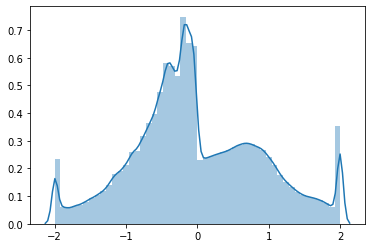

In [39]:
influence_pos = norm_scale_influe(comb_influe_pos, clip_value=2)
sns.distplot(influence_pos.values)

In [40]:
draw_influ_clustermap(influence_pos, anno, show_fig=False,
               save_prefix=prefix, save_dendrogram=True)

<Figure size 432x720 with 0 Axes>

In [41]:
bin_influ = binary_influ(influence_pos)
bin_influ.iloc[:5,:4]

1.2136603832244874 0.0


,"(0, 2)","(0, 4)","(0, 8)","(0, 10)"
Cell,,,,
Cells_Head_CTTCATTTGATG,0.0,0.0,0.0,0.0
Cells_Trunk_ACTTCCCCCGGN,0.0,0.0,0.0,0.0
Cells_Head_CTCTCTGTACTT,0.0,0.0,0.0,0.0
Cells_Head_TTGTCTAAAGGC,0.0,0.0,0.0,0.0
Cells_Pharynx_CCTCCCGCCGGC,0.0,0.0,0.0,0.0


In [42]:
draw_influ_clustermap(bin_influ, anno, show_fig=False,
               save_prefix= prefix+"_bin", 
               col_cluster=True, cmap='Greys', 
                save_dendrogram=True)

saving dendrogram


<Figure size 432x720 with 0 Axes>

In [43]:
anno_celltype = anno_color.drop_duplicates(["Celltype", "Cellcluster"]).set_index("Celltype")
influ_celltype = influence_pos.groupby(anno_color.Celltype).mean()
influ_celltype.iloc[:5,:4]

,"(0, 2)","(0, 4)","(0, 8)","(0, 10)"
Celltype,,,,
Cathepsin+_cells_C10,0.737532,-0.051714,0.041543,0.689791
Cathepsin+_cells_C15,0.794479,0.096089,0.179678,0.814196
Cathepsin+_cells_C17,0.731909,-0.129997,-0.087503,0.655000
Cathepsin+_cells_C28,0.709063,-0.262024,-0.281109,0.627826
Cathepsin+_cells_C31,0.612397,-0.259800,-0.227731,0.469884


In [44]:
draw_influ_clustermap(influ_celltype, anno_celltype, show_fig=False,
               save_prefix= prefix+"_celltype", 
               col_cluster=False, cmap='vlag')

<Figure size 432x720 with 0 Axes>

In [45]:
melt_influ(influ_celltype).to_csv(prefix+"_celltype.csv")

In [46]:
bin_influ_celltype = binary_influ(influ_celltype)
bin_influ_celltype.iloc[:5,:4]

1.619410252571106 0.0


,"(0, 2)","(0, 4)","(0, 8)","(0, 10)"
Celltype,,,,
Cathepsin+_cells_C10,0.0,0.0,0.0,0.0
Cathepsin+_cells_C15,0.0,1.0,1.0,1.0
Cathepsin+_cells_C17,0.0,0.0,0.0,0.0
Cathepsin+_cells_C28,0.0,0.0,0.0,0.0
Cathepsin+_cells_C31,0.0,0.0,0.0,0.0


In [47]:
draw_influ_clustermap(bin_influ_celltype, anno_celltype, show_fig=False,
               save_prefix= prefix+"_celltype_bin", 
               col_cluster=True, cmap='Greys', 
                save_dendrogram=True)

saving dendrogram


<Figure size 432x720 with 0 Axes>

In [48]:
anno_cluster = anno_color.drop_duplicates(["Cellcluster"])
anno_cluster.index = anno_cluster.Cellcluster

influ_cluster = influence_pos.groupby(anno_color.Cellcluster).mean()
influ_cluster.iloc[:5,:4]

,"(0, 2)","(0, 4)","(0, 8)","(0, 10)"
Cellcluster,,,,
Cathepsin,0.496446,-0.097366,-0.045291,0.408701
Epithelial,-0.458432,-0.260786,-0.278139,-0.614253
Intestine,0.232950,-0.262024,-0.281109,0.149821
Muscle,-0.754153,-0.190067,-0.191650,-0.529008
Neoblast,-0.038979,-0.262024,-0.279135,-0.109556


In [49]:
draw_influ_clustermap(influ_cluster, anno_cluster, show_fig=False,
               save_prefix= prefix+"_cluster", 
               col_cluster=True, cmap='vlag')

/home/ggj/anaconda3/envs/sc/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<Figure size 432x720 with 0 Axes>

In [50]:
melt_influ(influ_cluster, Var="Cluster").to_csv(prefix+"_cluster.csv")

# combination.negative.influence

In [51]:
prefix = "./Influence/comb_nagative_influence"

In [52]:
comb_influe_neg = comb_influe.copy()
comb_influe_neg[comb_influe_pos < 0] = 0
comb_influe_neg = comb_influe_neg.loc[:,comb_influe_neg.sum(0)!=0]
comb_influe_neg = comb_influe_neg.loc[anno.loc[comb_influe_neg.index].sort_values(["Cellcluster", "Celltype"]).index]
comb_influe_neg.iloc[:5,:4]

,"(0, 1)","(0, 2)","(0, 3)","(0, 4)"
Cell,,,,
Cells_Head_CTTCATTTGATG,-0.101219,0.015740,-0.020711,-0.004243
Cells_Trunk_ACTTCCCCCGGN,-0.156950,0.024397,-0.035416,-0.001691
Cells_Head_CTCTCTGTACTT,-0.131599,0.020040,-0.028567,-0.003737
Cells_Head_TTGTCTAAAGGC,-0.110391,0.018384,-0.023869,-0.001643
Cells_Pharynx_CCTCCCGCCGGC,-0.145273,0.021543,-0.032025,-0.004891


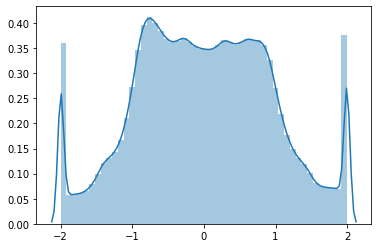

In [53]:
influence_neg = norm_scale_influe(comb_influe_neg, clip_value=2)
sns.distplot(influence_neg.values)

In [40]:
draw_influ_clustermap(influence_neg, anno, show_fig=False,
               save_prefix=prefix, save_dendrogram=True)

<Figure size 432x720 with 0 Axes>

In [41]:
bin_influ = binary_influ(influence_neg)
bin_influ.iloc[:5,:4]

1.2136603832244874 0.0


,"(0, 2)","(0, 4)","(0, 8)","(0, 10)"
Cell,,,,
Cells_Head_CTTCATTTGATG,0.0,0.0,0.0,0.0
Cells_Trunk_ACTTCCCCCGGN,0.0,0.0,0.0,0.0
Cells_Head_CTCTCTGTACTT,0.0,0.0,0.0,0.0
Cells_Head_TTGTCTAAAGGC,0.0,0.0,0.0,0.0
Cells_Pharynx_CCTCCCGCCGGC,0.0,0.0,0.0,0.0


In [42]:
draw_influ_clustermap(bin_influ, anno, show_fig=False,
               save_prefix= prefix+"_bin", 
               col_cluster=True, cmap='Greys', 
                save_dendrogram=True)

saving dendrogram


<Figure size 432x720 with 0 Axes>

In [54]:
anno_celltype = anno_color.drop_duplicates(["Celltype", "Cellcluster"]).set_index("Celltype")
influ_celltype = influence_neg.groupby(anno_color.Celltype).mean()
influ_celltype.iloc[:5,:4]

,"(0, 1)","(0, 2)","(0, 3)","(0, 4)"
Celltype,,,,
Cathepsin+_cells_C10,0.724112,-0.824260,0.792711,-0.800578
Cathepsin+_cells_C15,0.689164,-0.837068,0.821389,-0.834451
Cathepsin+_cells_C17,0.850946,-0.855749,0.705626,-0.806117
Cathepsin+_cells_C28,0.960708,-0.882368,0.767951,-0.805436
Cathepsin+_cells_C31,1.045830,-0.858535,0.771061,-0.691212


In [55]:
draw_influ_clustermap(influ_celltype, anno_celltype, show_fig=False,
               save_prefix= prefix+"_celltype", 
               col_cluster=False, cmap='vlag')

<Figure size 432x720 with 0 Axes>

In [56]:
melt_influ(influ_celltype).to_csv(prefix+"_celltype.csv")

In [57]:
# bin_influ_celltype = binary_influ(influ_celltype)
# bin_influ_celltype.iloc[:5,:4]

1.4774232864379893 0.14698199033737183


,"(0, 1)","(0, 2)","(0, 3)","(0, 4)"
Celltype,,,,
Cathepsin+_cells_C10,1.0,0.0,1.0,0.0
Cathepsin+_cells_C15,1.0,0.0,1.0,0.0
Cathepsin+_cells_C17,1.0,0.0,0.0,0.0
Cathepsin+_cells_C28,1.0,0.0,0.0,0.0
Cathepsin+_cells_C31,1.0,0.0,1.0,0.0


In [59]:
# draw_influ_clustermap(bin_influ_celltype, anno_celltype, show_fig=False,
#                save_prefix= prefix+"_celltype_bin", 
#                col_cluster=True, cmap='Greys', 
#                 save_dendrogram=True)

In [60]:
anno_cluster = anno_color.drop_duplicates(["Cellcluster"])
anno_cluster.index = anno_cluster.Cellcluster

influ_cluster = influence_neg.groupby(anno_color.Cellcluster).mean()
influ_cluster.iloc[:5,:4]

,"(0, 1)","(0, 2)","(0, 3)","(0, 4)"
Cellcluster,,,,
Cathepsin,0.690196,-0.666508,0.439839,-0.594720
Epithelial,-0.217136,0.262136,-0.267226,0.254784
Intestine,-0.136051,-0.205211,0.447054,-0.285471
Muscle,-0.622279,0.828677,-0.625200,0.794665
Neoblast,0.142983,-0.076228,0.461859,-0.073398


In [61]:
draw_influ_clustermap(influ_cluster, anno_cluster, show_fig=False,
               save_prefix= prefix+"_cluster", 
               col_cluster=True, cmap='vlag')

/home/ggj/anaconda3/envs/sc/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<Figure size 432x720 with 0 Axes>

In [62]:
melt_influ(influ_cluster, Var="Cluster").to_csv(prefix+"_cluster.csv")